Shape of scaled_data: (20, 5)
X_train shape before reshaping: (12, 2, 5)
X_val shape before reshaping: (1, 2, 5)
X_test shape before reshaping: (1, 2, 5)
X_train shape after reshaping: (12, 2, 5)
X_val shape after reshaping: (1, 2, 5)
X_test shape after reshaping: (1, 2, 5)
Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - loss: 0.1706WARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x30e05b6a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step - loss: 0.1706 - val_loss: 0.8257
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1619 - val_loss: 0.7928
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1532 - val_loss: 0.7601
Ep

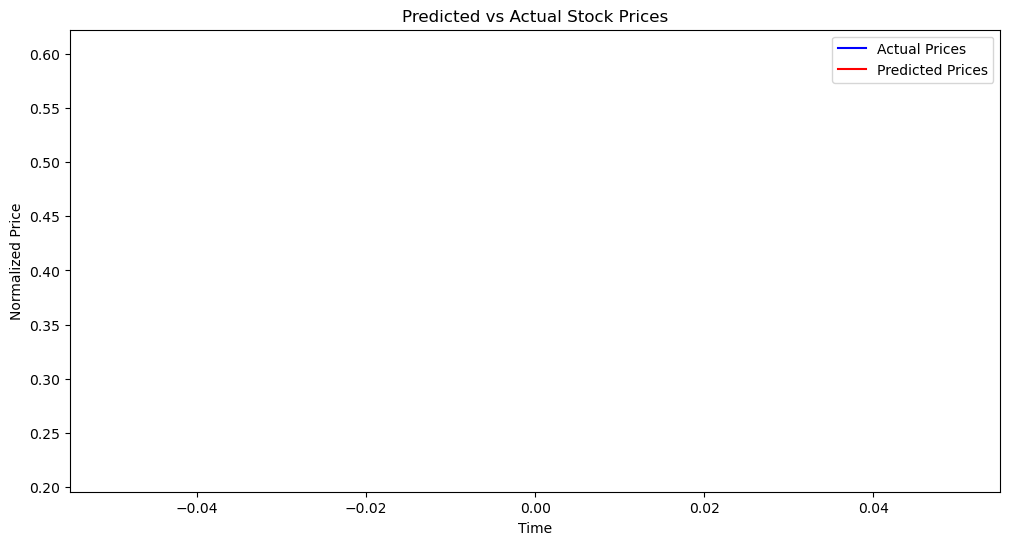

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset (updated file name)
data = pd.read_csv('Google_Stock_Price_Test.csv')  # Replace with your dataset path

# Remove commas from the 'Volume' column and convert columns to numeric
data['Volume'] = data['Volume'].replace({',': ''}, regex=True)  # Remove commas from the 'Volume' column
data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')  # Convert 'Volume' to numeric (float)

# Convert other columns to numeric if necessary (e.g., 'Open', 'High', 'Low', 'Close')
data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
data['High'] = pd.to_numeric(data['High'], errors='coerce')
data['Low'] = pd.to_numeric(data['Low'], errors='coerce')
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Handle missing data by forward filling
data = data.ffill()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Check the shape of scaled_data to ensure it's not empty
print(f"Shape of scaled_data: {scaled_data.shape}")

# Function to create sequences for RNN input
def create_sequences(data, sequence_length):
    X, y = [], []
    # Ensure that the dataset is large enough to create sequences
    if len(data) < sequence_length:
        print(f"Error: dataset too small to create sequences of length {sequence_length}")
        return np.array(X), np.array(y)
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # Last `sequence_length` data points
        y.append(data[i, 3])  # Target is the 'Close' price (4th column)
    return np.array(X), np.array(y)

# Define sequence length and split data (further reduce sequence length to 2)
sequence_length = 2  # Reduce the sequence length to 2 due to the small dataset

# Adjust the split to ensure non-zero validation and test data
train_size = int(len(scaled_data) * 0.7)  # 70% for training
validation_size = int(len(scaled_data) * 0.15)  # 15% for validation
test_size = len(scaled_data) - train_size - validation_size  # Remaining for test

train_data = scaled_data[:train_size]
validation_data = scaled_data[train_size:train_size + validation_size]
test_data = scaled_data[train_size + validation_size:]

# Generate training, validation, and test sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(validation_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Check the shapes of X_train, X_val, and X_test before reshaping
print(f"X_train shape before reshaping: {X_train.shape}")
print(f"X_val shape before reshaping: {X_val.shape}")
print(f"X_test shape before reshaping: {X_test.shape}")

# Ensure that the sequences are being generated properly
if X_train.shape[0] > 0 and X_val.shape[0] > 0 and X_test.shape[0] > 0:
    # Reshape the data to be 3D as required by LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Shape: (samples, sequence_length, features)
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))  # Same reshape for validation data
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # Same reshape for test data

    # Check the shapes after reshaping
    print(f"X_train shape after reshaping: {X_train.shape}")
    print(f"X_val shape after reshaping: {X_val.shape}")
    print(f"X_test shape after reshaping: {X_test.shape}")
else:
    print("Error: Unable to generate sequences due to insufficient data length.")

# Build an LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  # Input shape corrected
    LSTM(50),
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model on the test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()
